First import libraries and load data.

In [62]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from IPython.display import clear_output
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline, make_union
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from scipy.stats import randint, uniform
import xgboost as xgb
import process_data
import classifier
reload(classifier)
%matplotlib inline

df_x, x, y = classifier.load_data('output_7.pkl')

print df_x.columns.values[:30]  # print the first 30 columns


['home_start_p1_FG3_PCT' 'home_start_p1_FG_PCT' 'home_start_p1_FT_PCT'
 'home_start_p1_MIN' 'home_start_p1_PF' 'home_start_p1_PLUS_MINUS'
 'home_start_p1_PTS' 'home_start_p1_3PAr' 'home_start_p1_ASTr'
 'home_start_p1_BLKr' 'home_start_p1_DRBr' 'home_start_p1_DRtg'
 'home_start_p1_DWS' 'home_start_p1_FTr' 'home_start_p1_ORBr'
 'home_start_p1_ORtg' 'home_start_p1_OWS' 'home_start_p1_STLr'
 'home_start_p1_TOVr' 'home_start_p1_TRBr' 'home_start_p1_TS'
 'home_start_p1_USGr' 'home_start_p1_WS' 'home_start_p1_WS48'
 'home_start_p1_atb3_freq' 'home_start_p1_atb3_pps' 'home_start_p1_c3_freq'
 'home_start_p1_c3_pps' 'home_start_p1_mid_freq' 'home_start_p1_mid_pps']


TEST ERROR = 0.4835582
TRAIN ERROR = 0.1700044


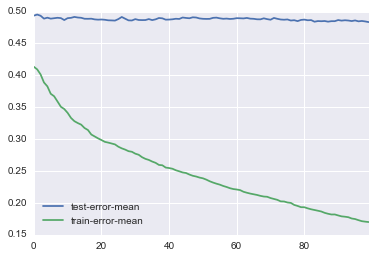

In [47]:
dtrain = xgb.DMatrix(x, label=y)
param = {'max_depth': 6, 'eta': 0.01, 'silent': 1, 'objective': 'binary:logistic', 'colsample_bytree': 1, 'min_child_weight': 1, 'seed': 22387}
num_round = 100

cvresults = xgb.cv(param, dtrain, num_round, nfold=5, seed=1233)

print 'TEST ERROR = ' + str(cvresults['test-error-mean'].values[-1])
print 'TRAIN ERROR = ' + str(cvresults['train-error-mean'].values[-1])

cvresults[['test-error-mean', 'train-error-mean']].plot()

Model overfits like crazy w/ fairly default parameters. Setting some really extreme parameters to try to get the model to underfit...

TEST ERROR = 0.4774874
TRAIN ERROR = 0.4633854


Will train until cv error hasn't decreased in 100 rounds.


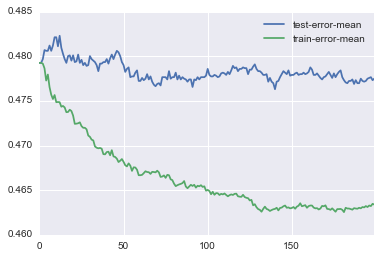

In [43]:
param = {'max_depth': 2, 'eta': 0.0000001, 'silent': 1, 'objective': 'binary:logistic', 'colsample_bytree': 0.1, 'min_child_weight': 100, 'seed': 22387}
num_round = 200

cvresults = xgb.cv(param, dtrain, num_round, nfold=5, seed=1233, early_stopping_rounds=100)

print 'TEST ERROR = ' + str(cvresults['test-error-mean'].values[-1])
print 'TRAIN ERROR = ' + str(cvresults['train-error-mean'].values[-1])

cvresults[['test-error-mean', 'train-error-mean']].plot()


Model actually seems to perform better when underfit. Now that we've traded variance for bias, gonna try to trade some of the bias back the other way with a grid search. Picking a broad spectrum of parameters so I can see some differences and trends.

In [44]:
kf = KFold(len(df_x.index), n_folds=5, shuffle=True, random_state=43123)
clf = xgb.XGBClassifier(n_estimators=300, colsample_bytree=.15, min_child_weight=10, seed=22387, learning_rate=0.0001)

param_grid = {'max_depth': [2, 4, 6], 'colsample_bytree': [0.05, 0.15, 0.3], 'min_child_weight':[10, 50, 100]}
num_round = 200

grid_search = GridSearchCV(clf, param_grid, cv=kf, verbose=1)
grid_search.fit(x, y)


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    9.1s
[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed: 10.8min


Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed: 57.2min finished


AttributeError: 'GridSearchCV' object has no attribute 'scores_'

In [46]:
classifier.report(grid_search.grid_scores_, 5)  # checking what the top 5 were

0.  Mean validation score: 0.527 (std: 0.006)
Parameters: {'colsample_bytree': 0.3, 'max_depth': 6, 'min_child_weight': 10}
1.  Mean validation score: 0.526 (std: 0.004)
Parameters: {'colsample_bytree': 0.15, 'max_depth': 6, 'min_child_weight': 10}
2.  Mean validation score: 0.526 (std: 0.005)
Parameters: {'colsample_bytree': 0.15, 'max_depth': 4, 'min_child_weight': 10}
3.  Mean validation score: 0.525 (std: 0.007)
Parameters: {'colsample_bytree': 0.3, 'max_depth': 2, 'min_child_weight': 10}
4.  Mean validation score: 0.525 (std: 0.006)
Parameters: {'colsample_bytree': 0.3, 'max_depth': 4, 'min_child_weight': 10}


In [55]:
dataholder = []
for param in param_grid:
    for search in grid_search.grid_scores_:
        param_value = search.parameters[param]
        score = search.mean_validation_score
        dataholder.append([param, param_value, score])
    
df_param_search = pd.DataFrame.from_records(dataholder, columns=['param', 'value', 'score'])
df_param_search = df_param_search.set_index('param')


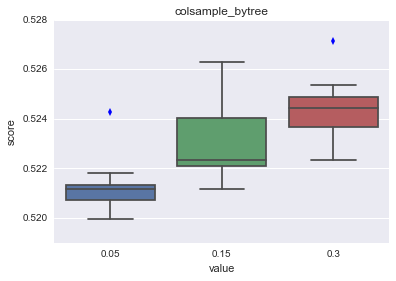

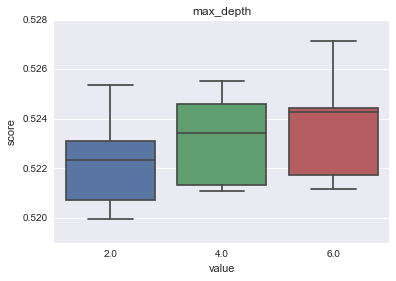

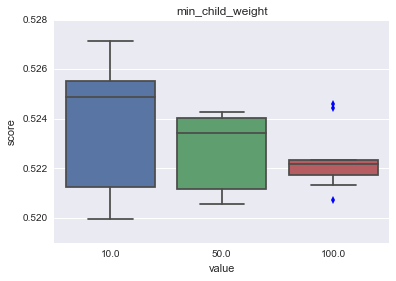

In [60]:

f, axarr = plt.subplot(1, len(param_grid.keys()), sharey=True)
for num, param in enumerate(param_grid):
    axarr[num] = sns.boxplot(x='value', y='score', data=df_param_search.loc[param])
    sns.plt.title(param)

sns.plt.show()

So it looks like out of that small grid of params, best was colsample_bytree = 0.3, max_depth, = 6, min_child_weight = 10. 

Still feel like it's not that well tuned....going to try a big ass randomized search, cya in a few hours

In [67]:
kf = KFold(len(df_x.index), n_folds=5, shuffle=True, random_state=43123)
clf = xgb.XGBClassifier(n_estimators=250, colsample_bytree=0.3, min_child_weight=10, seed=22387, learning_rate=0.01)

param_dist = {'max_depth': randint(6, 10), 'colsample_bytree': uniform(0.3, 0.55), 
              'min_child_weight': randint(5, 25), 'gamma': uniform(0,6), 'learning_rate': uniform(0.0001, 0.01)}

random_search = RandomizedSearchCV(clf, param_dist, cv=kf, verbose=100, n_iter=80, n_jobs=-1)
random_search.fit(x, y)
clear_output()
classifier.report(random_search.grid_scores_, 5)

0.  Mean validation score: 0.531 (std: 0.008)
Parameters: {'learning_rate': 0.005162380567623438, 'colsample_bytree': 0.40883969499226597, 'max_depth': 8, 'gamma': 4.3543518817614215, 'min_child_weight': 23}
1.  Mean validation score: 0.530 (std: 0.006)
Parameters: {'learning_rate': 0.0075680688239589435, 'colsample_bytree': 0.7372409838532645, 'max_depth': 6, 'gamma': 1.9821448878168364, 'min_child_weight': 7}
2.  Mean validation score: 0.530 (std: 0.005)
Parameters: {'learning_rate': 0.003449384911040265, 'colsample_bytree': 0.7110508229059478, 'max_depth': 6, 'gamma': 4.309992277657045, 'min_child_weight': 15}
3.  Mean validation score: 0.530 (std: 0.006)
Parameters: {'learning_rate': 0.007598961785205061, 'colsample_bytree': 0.594052197647905, 'max_depth': 9, 'gamma': 1.5819181631128434, 'min_child_weight': 19}
4.  Mean validation score: 0.530 (std: 0.006)
Parameters: {'learning_rate': 0.003588716907243656, 'colsample_bytree': 0.4046798348922547, 'max_depth': 7, 'gamma': 5.91608419

In [88]:
dataholder = []
for param in param_dist:
    for search in random_search.grid_scores_:
        param_value = search.parameters[param]
        score = search.mean_validation_score
        dataholder.append([param, param_value, score])
    
df_param_search = pd.DataFrame.from_records(dataholder, columns=['param', 'value', 'score'])
df_param_search = df_param_search.set_index('param')

print pd.unique(df_param_search.index.values)

['gamma' 'learning_rate' 'colsample_bytree' 'max_depth' 'min_child_weight']


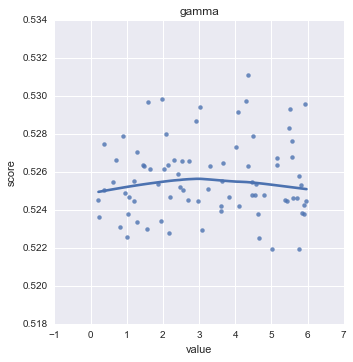

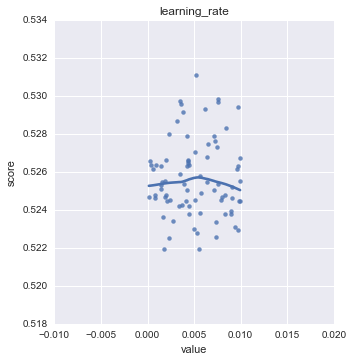

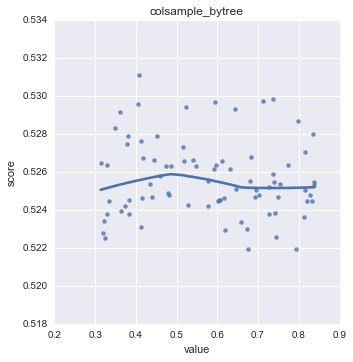

In [90]:
for param in ['gamma', 'learning_rate', 'colsample_bytree']:
    sns.lmplot(x='value', y='score', data=df_param_search.loc[param], lowess=True)
    sns.plt.title(param)
    sns.plt.show()

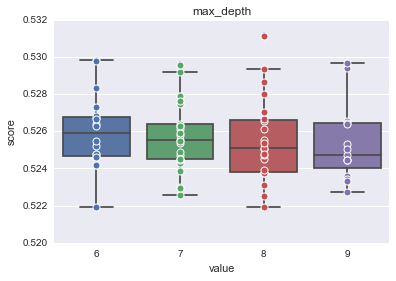

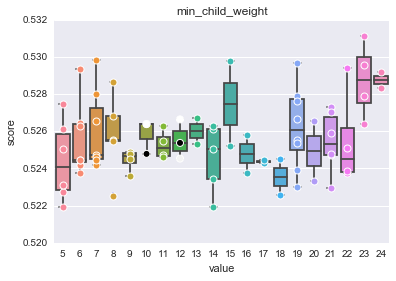

In [93]:
for param in ['max_depth', 'min_child_weight']:
    if param=='max_depth':
        order = np.arange(6, 10)
    else:
        order = np.arange(5, 25)
    sns.boxplot(x='value', y='score', data=df_param_search.loc[param], order=order)
    sns.stripplot(x='value', y='score', data=df_param_search.loc[param], order=order)
    sns.plt.title(param)
    sns.plt.show()

In [94]:
classifier.report(random_search.grid_scores_, 15)

0.  Mean validation score: 0.531 (std: 0.008)
Parameters: {'learning_rate': 0.005162380567623438, 'colsample_bytree': 0.40883969499226597, 'max_depth': 8, 'gamma': 4.3543518817614215, 'min_child_weight': 23}
1.  Mean validation score: 0.530 (std: 0.006)
Parameters: {'learning_rate': 0.0075680688239589435, 'colsample_bytree': 0.7372409838532645, 'max_depth': 6, 'gamma': 1.9821448878168364, 'min_child_weight': 7}
2.  Mean validation score: 0.530 (std: 0.005)
Parameters: {'learning_rate': 0.003449384911040265, 'colsample_bytree': 0.7110508229059478, 'max_depth': 6, 'gamma': 4.309992277657045, 'min_child_weight': 15}
3.  Mean validation score: 0.530 (std: 0.006)
Parameters: {'learning_rate': 0.007598961785205061, 'colsample_bytree': 0.594052197647905, 'max_depth': 9, 'gamma': 1.5819181631128434, 'min_child_weight': 19}
4.  Mean validation score: 0.530 (std: 0.006)
Parameters: {'learning_rate': 0.003588716907243656, 'colsample_bytree': 0.4046798348922547, 'max_depth': 7, 'gamma': 5.91608419

[0]	cv-test-error:0.490725+0.00757422825112	cv-train-error:0.4239252+0.00808367340755
[1]	cv-test-error:0.4892076+0.00478908306881	cv-train-error:0.3969646+0.00404853067668
[2]	cv-test-error:0.4916528+0.00175643381885	cv-train-error:0.3822514+0.00848298894494
[3]	cv-test-error:0.4892076+0.0059176751043	cv-train-error:0.3695824+0.00780424229762
[4]	cv-test-error:0.4849916+0.0061708774287	cv-train-error:0.3584738+0.0111551879661
[5]	cv-test-error:0.4846542+0.00227184237129	cv-train-error:0.3528248+0.0139809035674
[6]	cv-test-error:0.4815346+0.00622134495427	cv-train-error:0.3442666+0.0189171007567
[7]	cv-test-error:0.4852446+0.00792296706039	cv-train-error:0.342496+0.0216059255113
[8]	cv-test-error:0.4826308+0.00861263869903	cv-train-error:0.3415894+0.022436221862
[9]	cv-test-error:0.4845698+0.00865870284511	cv-train-error:0.3380902+0.0260349829299
[10]	cv-test-error:0.4833896+0.0112923369167	cv-train-error:0.3373104+0.0252543835767
[11]	cv-test-error:0.4833898+0.011994236039	cv-train-er

TEST ERROR = 0.4731872
TRAIN ERROR = 0.2172008


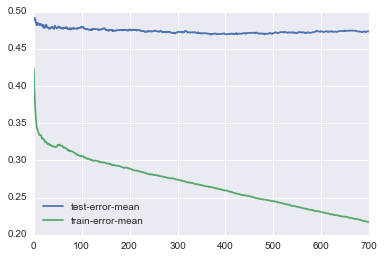

In [99]:
param = {'max_depth': 6, 'eta': 0.002, 'silent': 1, 'objective': 'binary:logistic', 'colsample_bytree': 0.4, 'min_child_weight': 30, 'seed': 34433, 'gamma': 4}
num_round = 700

cvresults = xgb.cv(param, dtrain, num_round, nfold=5, seed=1233, show_progress=True)

print 'TEST ERROR = ' + str(cvresults['test-error-mean'].values[-1])
print 'TRAIN ERROR = ' + str(cvresults['train-error-mean'].values[-1])

cvresults[['test-error-mean', 'train-error-mean']].plot()

In [100]:
kf = KFold(len(df_x.index), n_folds=5, shuffle=True, random_state=43123)
clf = xgb.XGBClassifier(n_estimators=250, max_depth=6, colsample_bytree=0.3, gamma=4.12, seed=22387, learning_rate=0.01)

param_dist = {'n_estimators': randint(400, 2000), 
              'min_child_weight': randint(30, 60), 'learning_rate': uniform(0.0001, 0.005)}

random_search = RandomizedSearchCV(clf, param_dist, cv=kf, verbose=10, n_iter=20, n_jobs=1)
random_search.fit(x, y)
clear_output()
classifier.report(random_search.grid_scores_, 5)

0.  Mean validation score: 0.533 (std: 0.009)
Parameters: {'n_estimators': 426, 'learning_rate': 0.004628774388547469, 'min_child_weight': 37}
1.  Mean validation score: 0.531 (std: 0.004)
Parameters: {'n_estimators': 548, 'learning_rate': 0.004214071601092479, 'min_child_weight': 43}
2.  Mean validation score: 0.530 (std: 0.005)
Parameters: {'n_estimators': 991, 'learning_rate': 0.0023126859477618105, 'min_child_weight': 44}
3.  Mean validation score: 0.530 (std: 0.003)
Parameters: {'n_estimators': 1392, 'learning_rate': 0.0011591303043999195, 'min_child_weight': 40}
4.  Mean validation score: 0.529 (std: 0.007)
Parameters: {'n_estimators': 1526, 'learning_rate': 0.001579757537910586, 'min_child_weight': 35}


In [101]:
dataholder = []
for param in param_dist:
    for search in random_search.grid_scores_:
        param_value = search.parameters[param]
        score = search.mean_validation_score
        dataholder.append([param, param_value, score])
    
df_param_search = pd.DataFrame.from_records(dataholder, columns=['param', 'value', 'score'])
df_param_search = df_param_search.set_index('param')

print pd.unique(df_param_search.index.values)

['n_estimators' 'learning_rate' 'min_child_weight']


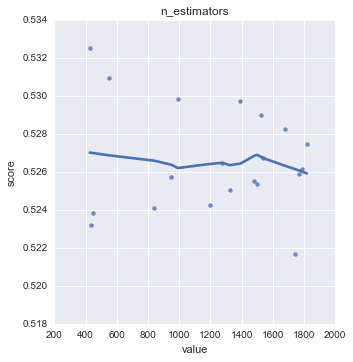

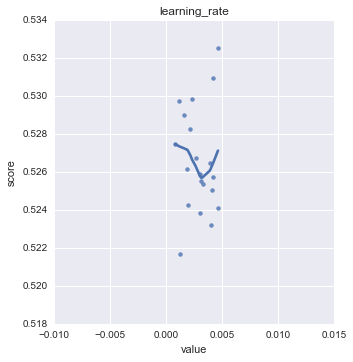

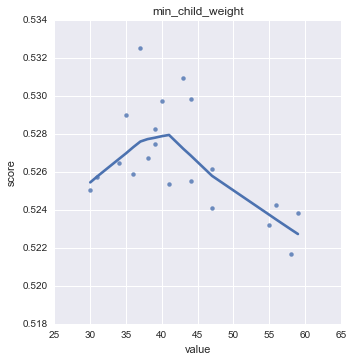

In [102]:
for param in ['n_estimators', 'learning_rate', 'min_child_weight']:
    sns.lmplot(x='value', y='score', data=df_param_search.loc[param], lowess=True)
    sns.plt.title(param)
    sns.plt.show()

In [106]:
param = {'max_depth': 6, 'eta': 0.005, 'silent': 1, 'objective': 'binary:logistic', 
         'colsample_bytree': 0.3, 'min_child_weight': 37, 'seed': 233, 'gamma': 4}
num_round = 400

cvresults = xgb.cv(param, dtrain, num_round, nfold=5, seed=12323, show_progress=True)

print 'TEST ERROR = ' + str(cvresults['test-error-mean'].values[-1])
print 'TRAIN ERROR = ' + str(cvresults['train-error-mean'].values[-1])

[0]	cv-test-error:0.4941822+0.01202926705	cv-train-error:0.4287732+0.00857047357851
[1]	cv-test-error:0.487774+0.00462591984366	cv-train-error:0.4030984+0.0108375281425
[2]	cv-test-error:0.484317+0.00553170758446	cv-train-error:0.3838534+0.0117891671563
[3]	cv-test-error:0.4868466+0.0033556855991	cv-train-error:0.374199+0.0125671253674
[4]	cv-test-error:0.4805228+0.00363034595597	cv-train-error:0.3682546+0.0122007493147
[5]	cv-test-error:0.4796796+0.00463650461447	cv-train-error:0.3622682+0.0133947333143
[6]	cv-test-error:0.478752+0.00497128345601	cv-train-error:0.359844+0.0142842591407
[7]	cv-test-error:0.4784994+0.00470214000642	cv-train-error:0.3552908+0.0143133519121
[8]	cv-test-error:0.4780776+0.00500237757871	cv-train-error:0.352108+0.0156036802326
[9]	cv-test-error:0.4809446+0.00295005007415	cv-train-error:0.3511172+0.0170994897631
[10]	cv-test-error:0.4804384+0.00437786169722	cv-train-error:0.3456786+0.0197446433809
[11]	cv-test-error:0.4790892+0.00351317482628	cv-train-error:0

TEST ERROR = 0.466189
TRAIN ERROR = 0.210118
